<a href="https://colab.research.google.com/github/HedersonSantos/SmartHome/blob/main/seriesTemporais_sarimax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
!pip install pmdarima

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('max_colwidth', None)


from statsmodels.tsa.stattools import acovf, acf, pacf, pacf_yw, pacf_ols
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # para determinar (p,q)
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.forecasting.theta import ThetaModel

from pmdarima.arima.utils import ndiffs
from pmdarima import auto_arima


from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.preprocessing import MinMaxScaler


In [34]:
!wget https://raw.githubusercontent.com/HedersonSantos/SmartHome/main/train.csv
!wget https://raw.githubusercontent.com/HedersonSantos/SmartHome/main/test.csv
!wget https://raw.githubusercontent.com/HedersonSantos/SmartHome/main/sample_submission.csv

--2022-05-21 19:02:09--  https://raw.githubusercontent.com/HedersonSantos/SmartHome/main/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 360467 (352K) [text/plain]
Saving to: ‘train.csv.1’

train.csv.1         100%[===================>] 352.02K  --.-KB/s    in 0.02s   

2022-05-21 19:02:09 (17.9 MB/s) - ‘train.csv.1’ saved [360467/360467]

--2022-05-21 19:02:10--  https://raw.githubusercontent.com/HedersonSantos/SmartHome/main/test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170613 (167K) [text/plain]
Saving to: 

In [100]:
def plotaSeries(treino, teste, predito):
  if type(treino) == pd.core.series.Series:
    treino.plot(legend=True,label='Treino')
  if type(teste) == pd.core.series.Series:
    teste.plot(legend=True,label='Teste',figsize=(16,8))
  if  type(predito)==pd.core.series.Series:
    predito.plot(legend=True) 
  else:
    for p in predito.columns:
      predito[p].plot(legend=True)

In [36]:
df_treino = pd.read_csv('train.csv')
df_treino['data_hora'] = df_treino.loc[:,['Date', 'Time']].apply(lambda x: datetime.strptime(x['Date'] + ' ' + x['Time'], '%d/%m/%Y %H:%M'), axis=1)
df_treino = df_treino.sort_values(by='data_hora')
df_treino = df_treino.set_index('data_hora')
idx = pd.date_range(start=df_treino.index.min(), end=df_treino.index.max(),  freq='0h15min')
df_treino= df_treino.reindex(idx)
df_treino.fillna(method='ffill', inplace=True)

In [37]:
min(df_treino.index), max(df_treino.index)

(Timestamp('2012-03-13 11:45:00', freq='15T'),
 Timestamp('2012-04-11 06:30:00', freq='15T'))

In [38]:
df_treino.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2764 entries, 2012-03-13 11:45:00 to 2012-04-11 06:30:00
Freq: 15T
Data columns (total 19 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Id                                2764 non-null   int64  
 1   Date                              2764 non-null   object 
 2   Time                              2764 non-null   object 
 3   CO2_(dinning-room)                2764 non-null   float64
 4   CO2_room                          2764 non-null   float64
 5   Relative_humidity_(dinning-room)  2764 non-null   float64
 6   Relative_humidity_room            2764 non-null   float64
 7   Lighting_(dinning-room)           2764 non-null   float64
 8   Lighting_room                     2764 non-null   float64
 9   Meteo_Rain                        2764 non-null   float64
 10  Meteo_Sun_dusk                    2764 non-null   float64
 11  Meteo_Wind             

In [39]:
df_treino.groupby('Date')['Id'].count().reset_index().sort_values('Date')

,Date,Id
0,01/04/2012,96
1,02/04/2012,96
2,03/04/2012,96
3,04/04/2012,96
4,05/04/2012,96
5,06/04/2012,96
6,07/04/2012,96
7,08/04/2012,96
8,09/04/2012,96
9,10/04/2012,96


In [40]:
df_treino = df_treino[df_treino['Date']!="13/03/2012"]
df_treino = df_treino[df_treino['Date']!="11/04/2012"]

In [41]:
df_treino.head(5)

,Id,Date,Time,CO2_(dinning-room),CO2_room,Relative_humidity_(dinning-room),Relative_humidity_room,Lighting_(dinning-room),Lighting_room,Meteo_Rain,Meteo_Sun_dusk,Meteo_Wind,Meteo_Sun_light_in_west_facade,Meteo_Sun_light_in_east_facade,Meteo_Sun_light_in_south_facade,Meteo_Sun_irradiance,Outdoor_relative_humidity_Sensor,Day_of_the_week,Indoor_temperature_room
2012-03-14 00:00:00,49,14/03/2012,00:00,217.835,223.381,41.4320,43.1573,11.6053,13.0207,0.0,0.650,0.0,0.0,0.0,0.0,-3.25067,57.5627,2.06667,19.5260
2012-03-14 00:15:00,50,14/03/2012,00:15,219.115,223.637,41.0427,43.1600,11.6053,13.5413,0.0,0.650,0.0,0.0,0.0,0.0,-3.31600,57.4720,3.00000,19.3733
2012-03-14 00:30:00,51,14/03/2012,00:30,219.200,225.131,41.0133,43.1520,11.5240,13.1027,0.0,0.738,0.0,0.0,0.0,0.0,-3.44667,57.7253,3.00000,19.2087
2012-03-14 00:45:00,52,14/03/2012,00:45,221.493,227.509,41.1520,43.1573,11.5240,13.2653,0.0,0.650,0.0,0.0,0.0,0.0,-3.44667,58.3413,3.00000,19.0527
2012-03-14 01:00:00,53,14/03/2012,01:00,222.229,226.208,41.1520,43.2400,11.5073,12.4353,0.0,0.650,0.0,0.0,0.0,0.0,-3.18533,58.4960,3.00000,18.8973


In [30]:
#df_treino['Meteo_Sun_dusk'] = df_treino['Meteo_Sun_dusk'].map(lambda x: x*100)

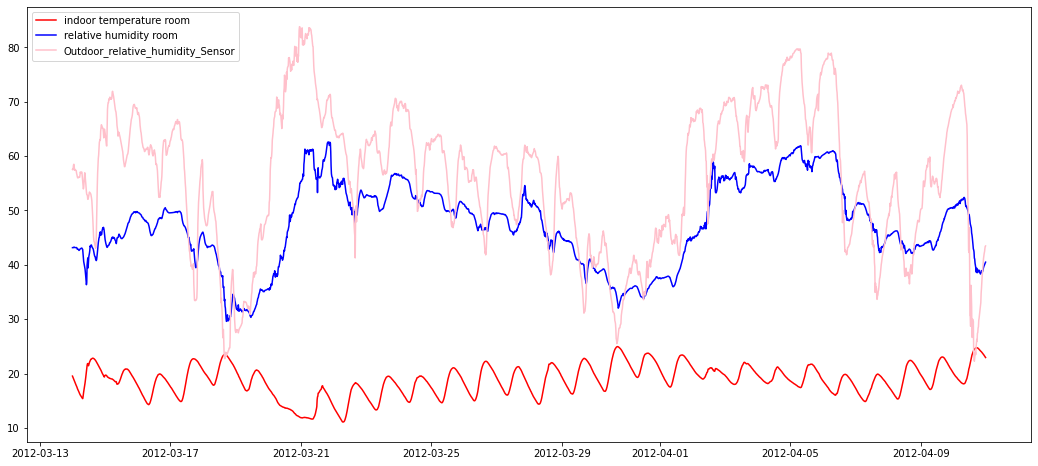

In [44]:
fig, ax = plt.subplots(figsize=(18,8))
plt.plot(df_treino['Indoor_temperature_room'], color='red', label = 'indoor temperature room')
plt.plot(df_treino['Relative_humidity_room'], color='blue', label = 'relative humidity room')
plt.plot(df_treino['Outdoor_relative_humidity_Sensor'], color='pink', label = 'Outdoor_relative_humidity_Sensor')
plt.legend()
plt.show()


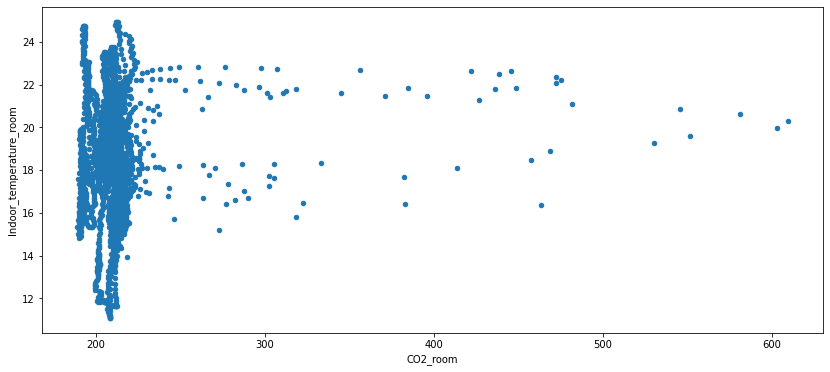

In [56]:
df_treino.plot.scatter('CO2_room','Indoor_temperature_room', figsize=(14,6))

In [80]:
#dividindo a amostra em treino e teste
dfTreino = df_treino[df_treino.index < datetime(2012,4,8,0,0)]
dfTeste = df_treino[df_treino.index >= datetime(2012,4,8,0,0)]
print(dfTreino.shape, dfTeste.shape)
print(min(dfTreino.index), max(dfTreino.index))
print(min(dfTeste.index), max(dfTeste.index))

(2400, 19) (288, 19)
2012-03-14 00:00:00 2012-04-07 23:45:00
2012-04-08 00:00:00 2012-04-10 23:45:00


In [81]:
from statsmodels.formula.api import ols

# Ajusta o modelo de regressão linear simples para Close com IBOV/1000 como preditora
modelo = ols('Indoor_temperature_room ~ Relative_humidity_room',data=dfTreino)
res = modelo.fit()

# valores ajustados de E(Y)
ypred=res.fittedvalues

# resíduo=observado-ajustado
residuo = res.resid

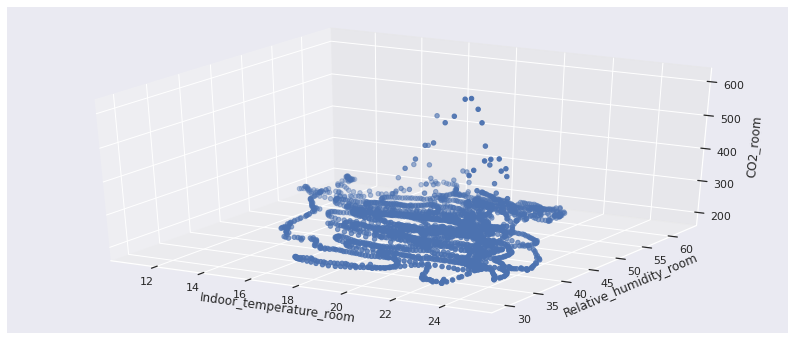

In [62]:
'''from mpl_toolkits.mplot3d import Axes3D
sns.set(style = "darkgrid")

fig = plt.figure( figsize=(14,6))
ax = fig.add_subplot(111, projection = '3d')

x = df_treino['Indoor_temperature_room']
y = df_treino['Relative_humidity_room']
z = df_treino['CO2_room']

ax.set_xlabel("Indoor_temperature_room")
ax.set_ylabel("Relative_humidity_room")
ax.set_zlabel("CO2_room")

ax.scatter(x, y, z)

plt.show()
'''

No handles with labels found to put in legend.


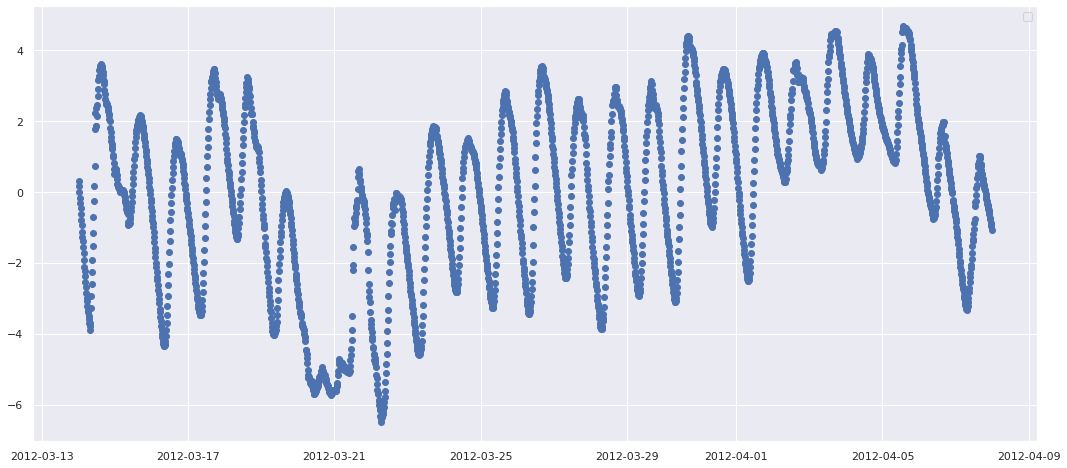

In [82]:
fig, ax = plt.subplots(figsize=(18,8))
plt.scatter(residuo.index,residuo)
plt.legend()
plt.show()

No handles with labels found to put in legend.


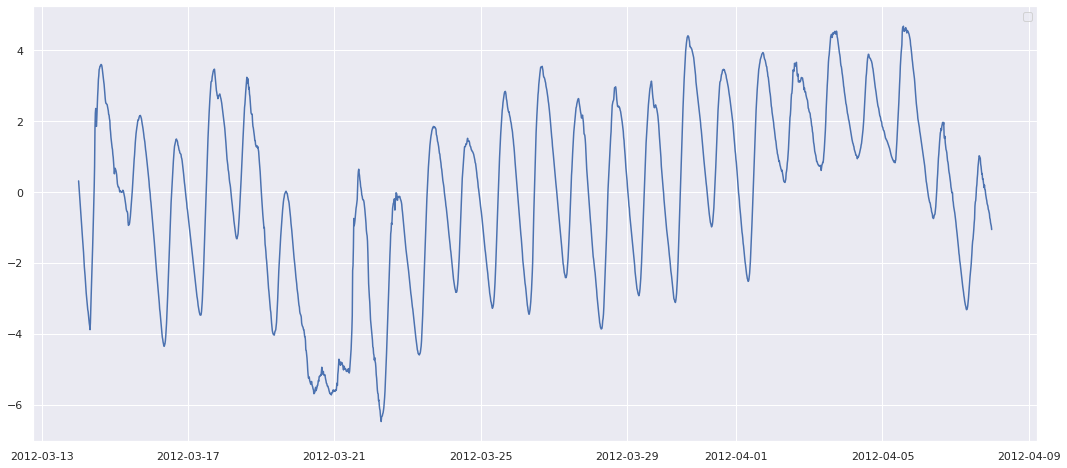

In [83]:
fig, ax = plt.subplots(figsize=(18,8))
plt.plot(residuo)
plt.legend()
plt.show()

In [84]:
stepwise_fit = auto_arima(residuo, start_p=4, start_q=4,
                          max_p=4, max_q=4, 
                          seasonal=False,
                          d=None, trace=True,
                          error_action='ignore',   
                          suppress_warnings=True,  
                          stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(4,1,4)(0,0,0)[0] intercept   : AIC=-6096.705, Time=9.71 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2562.587, Time=0.35 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5726.506, Time=0.85 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4060.479, Time=0.92 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2564.548, Time=0.21 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=-6144.058, Time=11.83 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=-6095.473, Time=10.56 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-6096.728, Time=5.86 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-6098.894, Time=2.80 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=-6097.386, Time=8.96 sec
 ARIMA(3,1,4)(0,0,0)[0]             : AIC=-6154.126, Time=3.20 sec
 ARIMA(2,1,4)(0,0,0)[0]             : AIC=-6097.455, Time=2.86 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=-6098.914, Time=2.56 sec
 ARIMA(4,1,4)(0,0,0)[0]             : AIC=-6100.244, Time=4.29 sec
 ARIMA(2,1,3)(0,0

In [85]:
endog = dfTreino['Relative_humidity_room']
exog = dfTreino['Indoor_temperature_room']

In [97]:
import statsmodels.api as sm

modelo = sm.tsa.statespace.SARIMAX(endog, exog, order=(3,1,3))
resultado = modelo.fit(disp=False)
print(resultado.summary())

                                 SARIMAX Results                                  
Dep. Variable:     Relative_humidity_room   No. Observations:                 2400
Model:                   SARIMAX(3, 1, 3)   Log Likelihood                -723.806
Date:                    Sat, 21 May 2022   AIC                           1463.612
Time:                            20:00:40   BIC                           1509.875
Sample:                        03-14-2012   HQIC                          1480.443
                             - 04-07-2012                                         
Covariance Type:                      opg                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Indoor_temperature_room    -0.4649      0.049     -9.488      0.000      -0.561      -0.369
ar.L1                       1.0832      0.045     24.315    

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [98]:
start=len(dfTreino)
end=len(dfTreino)+len(dfTeste)-1
exog_forecast = dfTeste[['Indoor_temperature_room']]  
previsao = resultado.predict(start=start, end=end, exog=exog_forecast).rename('SARIMAX')

In [101]:
dfTeste['SARIMAX']=previsao

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


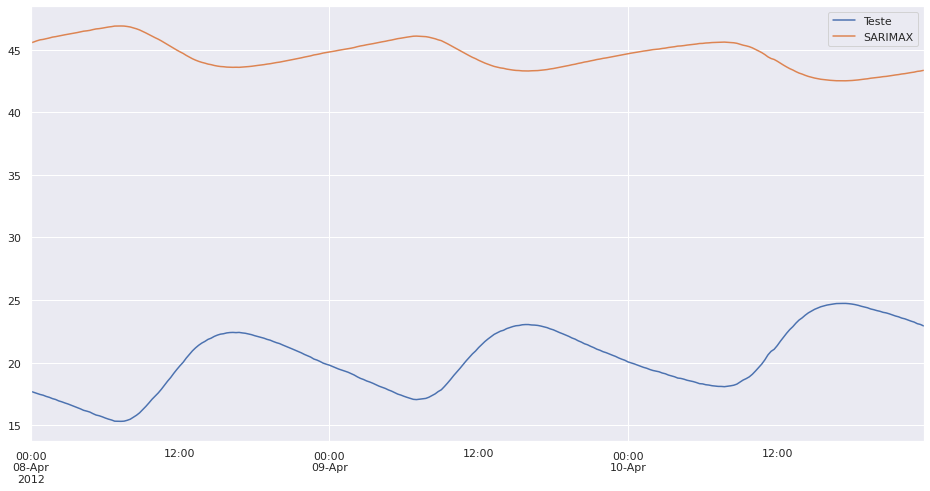

In [102]:
plotaSeries(None, dfTeste['Indoor_temperature_room'], dfTeste['SARIMAX'])